# Time series analysis with ARIMA
Some time ago I had a discussion about time series analysis and ARIMA models, which found me quite unprepared!
So I decided to look a bit closer to this neat piece of classical time series analysis. I found out that there are several excellent tutorials on how to use ARIMA, which I link below. Still, I found it useful to compile my own example to summarize my understanding of the problem and to collect links to useful resources.

## Import libraries and get sample data

In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

In [2]:
# set parameters
test_index = 11840
end_test_index = 15787
# testVal = 19434
testVal = 3947

update_frequency = 10

filename = 'threshold_T1.csv'

# threshold that will accept a prediction as valid
threshold = 0.02

# splitting the dataset 80%
skipVal = 15787
endVal = 19734

In [3]:
def set_validation_data(index):
    """
    Helper function to read testing data

    Args:
        index (int): Index of datapoint
    Returns:
        boolean: Returns false if datapoint is a validation point
    """
#     if test_index < index <= skipVal:
    if (test_index + 1) <= index < end_test_index:
#     if 201 <= index < 300:
        return False
    elif index == 0:
        return False
    else:
        return True

In [4]:
def set_testing_data(index):
    if index >= end_test_index:
        return False
    elif index == 0:
        return False
    else:
        return True

In [5]:
def calculate_mean_squared(predicted_val, actual_val):
    """

    Calculates mean squared error

    Args:
        predicted_val (int): Predicted value
        actual_val (int): Actual value

    Returns:
        mse (int): Mean squared error

    """
    # mse = math.sqrt(abs(actual_val - predicted_val))
    mse = pow((actual_val - predicted_val), 2)
    return mse

In [6]:
def check_abnormal_data(prediction, flag_dictionary, 
                        current_data, timestamp, 
                        true_positive, true_negative, 
                        false_positive, false_negative, 
                        flags):
    """

    Compare new data against the predicted timestamp.
    Places the timestamp of the data in true_positive, true_negative, 
        false_positive or false_negative.

    Args:
        prediction (int): Predicted next timestamp
        flag_dictionary (dict[int]): Dictionary that contains T/F flags that
            determine if datapoint is valid or not
        current_data (int): Data to be checked
        timestamp (int): Timestamp of the data to be checked
        true_positive (arr[int]): List of true positive timestamps
        true_negative (arr[int]): List of true negative timestamps
        false_positive (arr[int]): List of false positive timestamps
        false_negative (arr[int]): List of flase negative timestamps
        flags (arr[int]): list of T/F flags

    Returns:
        flags (arr[int]): list of T/F flags
        true_positive (arr[int]): List of true positive timestamps
        true_negative (arr[int]): List of true negative timestamps
        false_positive (arr[int]): List of false positive timestamps
        false_negative (arr[int]): List of flase negative timestamps
        output_flag (bool): Returns True if prediction was invalid 
            and False if prediction is valid

    """
    
    # determine limits of validation
    upper_limit = prediction * (1 + threshold)
    lower_limit = prediction * (1 - threshold)

#     print('Next_time_stamp_raw ' + str(prediction))
#     print('Upper limit ' + str(upper_limit))
#     print('Lower limit ' + str(lower_limit))
    
    # Compare data
    output_flag = None
    if float(current_data) > upper_limit or float(current_data) < lower_limit:
        flags.append(True)
        output_flag = True
        if timestamp in flag_dictionary:
            true_negative.append(timestamp)
        else:
            false_negative.append(timestamp)
    else:
        output_flag = False
        flags.append(False)
        if timestamp in flag_dictionary:
            false_positive.append(timestamp)
        else:
            true_positive.append(timestamp)
    
    return flags, true_positive, true_negative,\
        false_positive, false_negative, output_flag

In [7]:
def check_abnormal_test_data(prediction, current_data, 
                        timestamp, flags, valid_data):
    """

    Compare new data against the predicted timestamp.

    Args:
        prediction (int): Predicted next timestamp
        current_data (int): Data to be checked
        timestamp (int): Timestamp of the data to be checked
        predicted_invalid (arr[int]): list of predicted invalid data
        flags (arr[int]): list of T/F flags
        valid_data (arr[int]): list of valid data

    Returns:
        flags (arr[int]): list of T/F flags
        valid_data (arr[int]): List of valid data
        output_flag (bool): Returns True if prediction was invalid 
            and False if prediction is valid

    """
    
    # Calculate thresholds
    upper_limit = prediction * (1 + threshold)
    lower_limit = prediction * (1 - threshold)

    print('Next_time_stamp_raw ' + str(prediction))
    print('Upper limit ' + str(upper_limit))
    print('Lower limit ' + str(lower_limit))
    
    # Compare data
    output_flag = None
    if float(current_data) > upper_limit or float(current_data) < lower_limit:
        flags.append(True)
        output_flag = True
    else:
        output_flag = False
        flags.append(False)
        valid_data.append(current_data)
    
    return flags, valid_data, output_flag

In [8]:
def predict(results, index):
#     pred2 = results.get_forecast(test_index + index)
#     pred2_ci = pred2.conf_int()
#     print(pred2_ci)
#     print(pred2_ci.values[1][0])
#     prediction = (pred2_ci.values[1][0] + pred2_ci.values[1][1])/2
#     print(prediction)
    pred0 = results.get_prediction(start= test_index + index, dynamic=False)
    pred0_ci = pred0.conf_int()
    prediction = (pred0_ci.values[0][0] + pred0_ci.values[0][1])/2
    return prediction

# this function will predict a range in which the datapoint will be
# for the sake of this project, i am averaging these values

Get the classic international airline passengers data, downloadable from the DataMarket webpage (https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) as a CSV with filename "international-airline-passengers.csv".

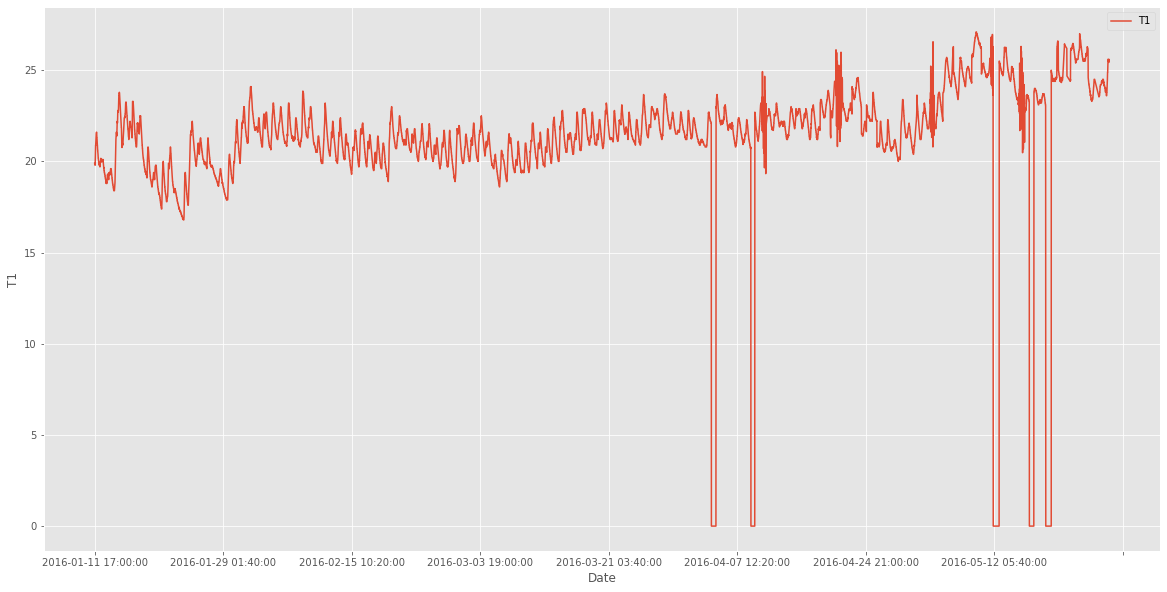

In [22]:
# Load the data
# 3947
data = pd.read_csv(filename, usecols=['date', 'T1'], index_col=0)
# data = pd.read_csv(filename, usecols=['date', 'T1'], index_col=0)

series = pd.read_csv(filename, sep=',', header=0, index_col=0, squeeze=True, skiprows=lambda x: set_validation_data(x), usecols=['date', 'T1_class'])

# seperate the data into individual arrays
timestamps = series.index
flag = series.values

# initialize dictionary
flag_dictionary = {}
for x in range(len(timestamps)):
    if flag[x] == True:
        flag_dictionary[timestamps[x]] = True

# Plot the data
data.plot()
plt.ylabel('T1')
plt.xlabel('Date')
plt.show()

Two obvious patterns appear in the data, an overall increase in the number of passengers over time, and a 12 months seasonality with peaks corresponding to the northern emisphere summer period.

## ARIMA
ARIMA stands for Auto-Regressive Integrated Moving Average. There are three  integers (p, d, q) that are used to parametrize ARIMA models. Because of that, a nonseasonal ARIMA model is denoted with ARIMA(p, d, q): 
<ul>
<li><strong>p</strong> is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.</li>
<li><strong>d</strong> is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.</li>
<li><strong>q</strong> is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.</li>
</ul>

When dealing with seasonal effects, as in our example, seasonal ARIMA is used, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the nonseasonal parameters described above, (<strong>P, D, Q</strong>) follow the same definition but are applied to the seasonal component of the time series. The term <strong>s</strong> is the periodicity of the time series.

While in this case it is clear that s=12, how do we set the other parameters? 

It is pretty much based on experience. There are numerous best practices that can be followed to identify ARIMA models, such as: 
http://people.duke.edu/~rnau/arimrule.htm.

Here we use grid search over all possible combinations of parameter values within a predefined range of values (heavily inspired by https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3). 

$statsmodels.tsa.statespace.sarimax.SARIMAXResults$ returns values for AIC (Akaike Information Criterion) and BIC (Bayes Information Criterion) that can be minimized to select the best fitting model. We use the AIC value, which estimates the information lost when a given model is used to represent the process that generates the data. In doing so, it deals with the trade-off between the goodness of fit of the model and the complexity of the model itself.

In [ ]:
# # Define the d and q parameters to take any value between 0 and 1
# q = d = range(0, 2)
# # Define the p parameters to take any value between 0 and 3
# p = range(0, 4)

# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))

# # Generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

We select a subset of the data series as training data, say the first 11 years. Our goal is to predict the last year of the series based on this input.

In [24]:
train_data = data[1:test_index]
test_data = data[(test_index + 1):end_test_index]
print(test_data)

                            T1
date                          
2016-04-02 22:30:00  21.000000
2016-04-02 22:40:00  21.000000
2016-04-02 22:50:00  21.000000
2016-04-02 23:00:00  21.000000
2016-04-02 23:10:00  21.000000
...                        ...
2016-04-30 07:20:00  21.390000
2016-04-30 07:30:00  21.290000
2016-04-30 07:40:00  21.356667
2016-04-30 07:50:00  21.390000
2016-04-30 08:00:00  21.390000

[3946 rows x 1 columns]


In [ ]:
# warnings.filterwarnings("ignore") # specify to ignore warning messages

# AIC = []
# SARIMAX_model = []
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(train_data,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             results = mod.fit()

#             print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
#             AIC.append(results.aic)
#             SARIMAX_model.append([param, param_seasonal])
#         except:
#             continue

In [ ]:
# print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

In [11]:
# Let's fit this model
# print(SARIMAX_model[AIC.index(min(AIC))][0])
# print(SARIMAX_model[AIC.index(min(AIC))][1])
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=(2,1,1),
                                seasonal_order=(0,0,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


Once the model has been fitted, we can check if does what we expect and if the assumptions we made are violated. To do this, we can use the $plot\_diagnostics$ method.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


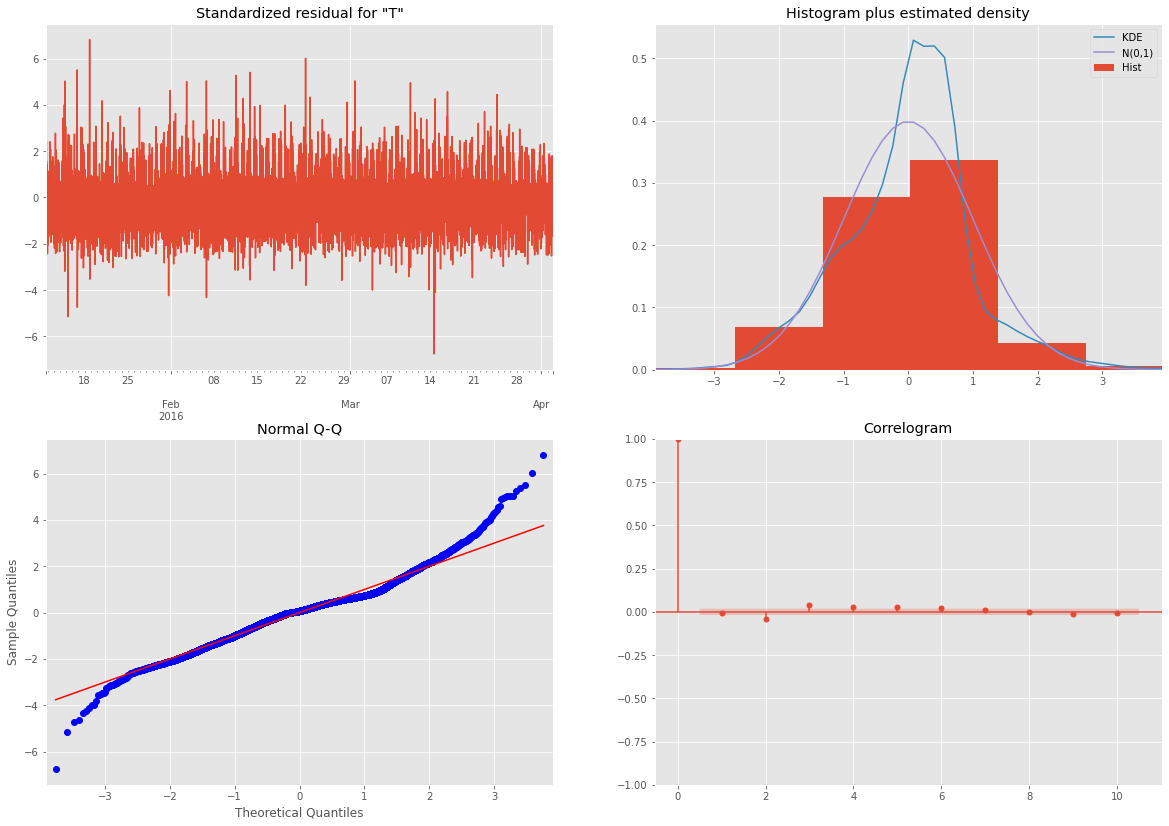

In [12]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In the plots above, we can observe that the residuals are uncorrelated (bottom right plot) and do not exhibit any obvious seasonality (the top left plot). Also, the residuals and roughly normally distributed with zero mean (top right plot). The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) roghly follows the linear trend of samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

## Results
Now let's create some predictions. We will use three methods:

1) In sample prediction with 1-step ahead forecasting of the last year (1959). In this case the model is used to predict data that the model was built on. 1-step ahead forecasting implies that each forecasted point is used to predict the following one.

In [ ]:
# print(results)
# pred0 = results.get_prediction(start=150, dynamic=False)
# print(pred0)
# pred0_ci = pred0.conf_int()
# print(pred0_ci)

2) In sample prediction with dynamic forecasting of the last year (1959). Again, the model is used to predict data that the model was built on.

In [ ]:
# pred1 = results.get_prediction(start=150, dynamic=True)
# pred1_ci = pred1.conf_int()

3) "True" forecasting of out of sample data. In this case the model is asked to predict data it has not seen before.

In [ ]:
# pred2 = results.get_forecast(test_index + 1)
# pred2_ci = pred2.conf_int()
# # print()
# prediction = (pred2_ci.values[0][0] + pred2_ci.values[0][1])/2
# print(prediction)
# print(pred2_ci)
# # print(pred2.predicted_mean[190:195])

# VALIDATION

i = 0
ind = 1

true_positive = []
true_negative = []
false_positive = []
false_negative = []

mse_values_validation = []
predicted_invalid_validation = []
flags_validation = []
valid_data_validation = []
current_data = []
predictions_validation = []

for validation_data in test_data.values:
    current_data.append(validation_data)
    # add new data point to array of data
    train_data = data[(1 + ind): (test_index + ind)]
#     print(train_data)
#     train_data.append(df)
#     train_data = pd.concat(train_data, df)
    
    # predict next timestamp
    prediction = predict(results, ind)
    predictions_validation.append(prediction)
    
    # calculate mse
    mse = calculate_mean_squared(prediction, validation_data)
    mse_values_validation.append(mse)
    
    # compare new data to predicted timestamp
    flags, true_positive, true_negative, false_positive,\
            false_negative, output_flag = check_abnormal_data(prediction, 
                                                 flag_dictionary, 
                                                 validation_data, 
                                                 timestamps[ind - 1], 
                                                 true_positive, 
                                                 true_negative, 
                                                 false_positive, 
                                                 false_negative, 
                                                 flags_validation)
    
    if i == update_frequency:
        mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=(2,1,1),
                                seasonal_order=(0,0,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

        results = mod.fit()
        i = 0
    ind = ind + 1
    i = i + 1
#     if ind == 200:
#         break

plt.figure()
plt.subplot(111)
plt.plot(current_data, label='Current Data')
plt.plot(mse_values_validation, label='mse')    
plt.legend()
plt.show()

plt.figure()
plt.subplot(111)
plt.plot(current_data, label='Current Data')
plt.plot(predictions_validation, label='Prediction')    
plt.legend()
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inf

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


Let's plot all this

In [14]:
# Export data
tp = pd.DataFrame(true_positive)
tp.to_csv('truePositive.csv')
tn = pd.DataFrame(true_negative)
tn.to_csv('trueNegative.csv')
fp = pd.DataFrame(false_positive)
fp.to_csv('falsePositive.csv')
fn = pd.DataFrame(false_negative)
fn.to_csv('falseNegative.csv')
mseExport = pd.DataFrame(mse_values_validation)
mseExport.to_csv('mseExport.csv')
# pred_inv = pd.DataFrame(predicted_invalid)
# pred_inv.to_csv("predicted_invalid.csv")
# print(test_data.values)
data_export_vals = {
        'Date': timestamps,
        'T1': current_data,
        'T1_e': mse_values_validation,
        'T1_c': flags_validation
    }
data_export = pd.DataFrame(data_export_vals)
data_export.to_csv("T1_report_final.csv", index=False)

In [21]:
# TESTING
# load test data (last 20%)
# this part might change based on how model takes in data
series = pd.read_csv(filename, sep=',', header=0, index_col=0, usecols=['date', 'T1'], squeeze=True, skiprows=lambda x: set_testing_data(x))
timestamps = series.index
testing_data = series.values


mse_values_testing = []
predicted_invalid_testing = []
flags_testing = []
valid_data_testing = []

current_data_testing = []
predictions_testing = []

i = 0
j = 0
ind = 1
for test_data in testing_data:
    current_data_testing.append(test_data)

    # add new data point to array of data
    # TODO: add test data to array
    train_data = data[(test_index + ind): (end_test_index + ind)]
    print(train_data)

    # predict next timestamp
    # TODO: predict next timestamp
    # predict next timestamp
    prediction = predict(results, ind)
    predictions_testing.append(prediction)

    # calculate mse
    # TODO: pass correct variable into mse (prediction)
    mse = calculate_mean_squared(prediction, test_data)
    mse_values_testing.append(mse)

    # Compare new data to predicted timestamp
    # TODO: pass correct variable into function (prediction)
    flags, valid_data, output_flag = check_abnormal_test_data(prediction, test_data, timestamps[ind - 1],
                                             flags_testing,   
                                             valid_data_testing)

#     # this is used for clustering
#     if output_flag == True:
#         predicted_invalid_testing.append([timestamps[s[ind - 1], ind - 1]])

    # upadte the model with new datapoints
    if i == update_frequency:
        mod = sm.tsa.statespace.SARIMAX(train_data,
                            order=(2,1,1),
                            seasonal_order=(0,0,0,12),
                            enforce_stationarity=False,
                            enforce_invertibility=False)

        results = mod.fit()
        i = 0
    ind = ind + 1
    i = i + 1
    if ind == 10:
        break


# Plot graph: predicted VS actual
# plt.figure()
# plt.subplot(111)
# plt.plot(current_data, label='Current Data')
# plt.plot(mse_values, label='mse')	
# plt.legend()
# plt.show()

# # Export data
# mseExport = pd.DataFrame(mse_values_testing)
# mseExport.to_csv('mseExport_test.csv')
# #     pred_inv = pd.DataFrame(predicted_invalid)
# #     pred_inv.to_csv("predicted_invalid_test.csv")


# data_export_vals = {
#         'Date': timestamps,
#         'T1': current_data,
#         'T1_e': mse_values_testing,
#         'T1_c': flags_testing
#     }
# data_export = pd.DataFrame(data_export_vals)
# data_export.to_csv("T1_report_final_test.csv", index=False)

                            T1
date                          
2016-04-02 22:30:00  21.000000
2016-04-02 22:40:00  21.000000
2016-04-02 22:50:00  21.000000
2016-04-02 23:00:00  21.000000
2016-04-02 23:10:00  21.000000
...                        ...
2016-04-30 07:30:00  21.290000
2016-04-30 07:40:00  21.356667
2016-04-30 07:50:00  21.390000
2016-04-30 08:00:00  21.390000
2016-04-30 08:10:00  21.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.388751830285994
Upper limit 21.816526866891714
Lower limit 20.960976793680274
                            T1
date                          
2016-04-02 22:40:00  21.000000
2016-04-02 22:50:00  21.000000
2016-04-02 23:00:00  21.000000
2016-04-02 23:10:00  21.000000
2016-04-02 23:20:00  21.000000
...                        ...
2016-04-30 07:30:00  21.290000
2016-04-30 07:40:00  21.356667
2016-04-30 07:50:00  21.390000
2016-04-30 08:00:00  21.390000
2016-04-30 08:10:00  21.390000

[3946 rows x 1 columns]
Next_time_stamp_raw 21.388751830285994
Uppe

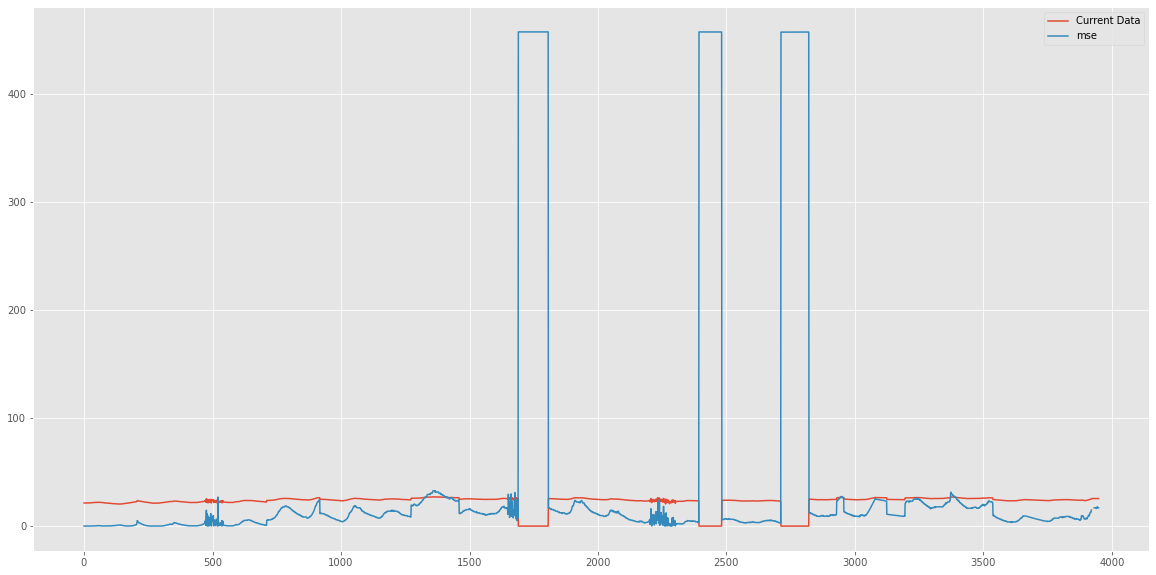

timestamp 3949
current_data 3946
mse_values_testing 3949
flag_testing 3949


In [19]:
# Plot graph: predicted VS actual
plt.figure()
plt.subplot(111)
plt.plot(current_data_testing, label='Current Data')
plt.plot(mse_values_testing, label='mse')	
plt.legend()
plt.show()

# Export data
mseExport = pd.DataFrame(mse_values_testing)
mseExport.to_csv('mseExport_test.csv')
#     pred_inv = pd.DataFrame(predicted_invalid)
#     pred_inv.to_csv("predicted_invalid_test.csv")

print("timestamp " + str(len(timestamps)))
print("current_data " + str(len(current_data)))
print("mse_values_testing " + str(len(mse_values_testing)))
print("flag_testing " + str(len(flags_testing)))

# data_export_vals = {
#         'Date': timestamps,
#         'T1': current_data,
#         'T1_e': mse_values_testing,
#         'T1_c': flags_testing
#     }
# data_export = pd.DataFrame(data_export_vals)
# data_export.to_csv("T1_report_final_test.csv", index=False)

In [ ]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

Looking at the figure, the model seems to do a pretty good job at modeling the time series. The blue and purple lines are, as expected, very close to the red ground truth. What is more interesting is the gray line, the out of sample predinction. For such a simple time series, the ARIMA model is able to forecast the 1960 values accurately.

In order to quantify the accuracy of the prediction for 1960, we can compute metrics such as Mean Absolute Error, Mean Squared Error, or Root Mean Squared Error. These are all absolute metrics, are therefore scale-dependent. While they are useful, and widely used to compare different methods on a same dataset, here it would be more useful to express the error relatively to the magnitude of the time series we are trying to predict. One commonly-used percentage error measure is the Mean Absolute Percentage Error (MAPE). It has some drawbacks in special cases (notably, it can lead to division by zero) and improved measures have been proposed, see e.g. https://www.otexts.org/fpp/2/5 for a nice overview. However, for this example we'll stick with MAPE.

In [ ]:
prediction = pred2.predicted_mean[151:200].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 1960 is {:.2f}%'.format(MAPE))